In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data set into pandas
df = pd.read_csv("heart_2022_with_nans.csv")

In [3]:
columns = ['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
           'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
           'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
           'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
           'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
           'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
           'DifficultyConcentrating', 'DifficultyWalking',
           'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
           'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
           'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
           'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
           'HighRiskLastYear', 'CovidPos']


# Check for duplicates based on the specified columns
num_duplication = df.duplicated(subset=columns).sum()
# print (f"The number of duplications: {num_duplication}")

In [4]:
# Remove duplicate rows based on the specified columns
No_Dup_DF = df.drop_duplicates(subset=columns, keep = "first").reset_index(drop=True)
print (f"The total number rows in dataset: {No_Dup_DF.shape[0]}")

The total number rows in dataset: 444975


In [5]:
# Check for NaN values
round(No_Dup_DF.isna().sum() / len(No_Dup_DF) * 100,2).sort_values()

State                         0.00
Sex                           0.00
HadDiabetes                   0.24
PhysicalActivities            0.24
GeneralHealth                 0.27
HadStroke                     0.35
HadAsthma                     0.40
HadKidneyDisease              0.43
HadCOPD                       0.50
HadArthritis                  0.59
HadDepressiveDisorder         0.63
HadHeartAttack                0.69
HadSkinCancer                 0.71
HadAngina                     0.99
SleepHours                    1.22
LastCheckupTime               1.87
MentalHealthDays              2.04
AgeCategory                   2.04
PhysicalHealthDays            2.45
RemovedTeeth                  2.55
RaceEthnicityCategory         3.16
DeafOrHardOfHearing           4.61
BlindOrVisionDifficulty       4.81
DifficultyDressingBathing     5.34
DifficultyWalking             5.36
DifficultyConcentrating       5.41
DifficultyErrands             5.73
HeightInMeters                6.41
SmokerStatus        

In [6]:
# Dropping columns w/ more than 60000 nan: 
columns = [column for column in No_Dup_DF.columns if No_Dup_DF[column].isna().sum() >= 60000]
df_cleaned = No_Dup_DF.drop(columns = columns)
df_cleaned = df_cleaned.dropna()
print (f"df_cleaned has {df_cleaned.shape[0]} rows")
print (f"df_cleaned has {df_cleaned.shape[1]} columns")
df_cleaned.to_csv("Cleaned_dataset.csv", index=False)

df_cleaned has 296352 rows
df_cleaned has 37 columns


In [7]:
# Load data set into pandas
df = pd.read_csv("Cleaned_dataset.csv")

In [8]:
# Identify binary columns
binary_columns = [column for column in df.columns if df[column].nunique() == 2]
# Convert binary columns to 0 and 1
for col in binary_columns:
    unique_values = df[col].unique()
    if set(unique_values) == {"Yes", "No"}:
        df[col] = df[col].map({"Yes": 1, "No": 0})

In [9]:
categorical_columns = ['Sex', 'GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'HadDiabetes',
                       'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory',
                       'HighRiskLastYear', 'CovidPos']

# Extract the categorical columns into a new DataFrame
Categorical_col = df[categorical_columns]

# Use pd.get_dummies to transform the categorical columns
Transform_df = pd.get_dummies(Categorical_col, dtype=int)


In [10]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=["float64"]).columns
df_numeric = df[numeric_columns]

# Create standard scaler instance, fitting it, and scaling it
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_columns)

In [11]:
# Drop the original columns
df = df.drop(columns=categorical_columns + numeric_columns.tolist())

# Combine the original DataFrame and the dummy variables DataFrame
merged_df = pd.concat([df, Transform_df, scaled_numeric_df], axis=1)
merged_df = merged_df.drop(columns='State')

In [12]:
merged_df.to_csv("processed_data.csv", index=False)

In [13]:
# Load data set into pandas
df_cleaned = pd.read_csv("processed_data.csv")
df_cleaned.head()

PhysicalActivities  HadHeartAttack  HadAngina  HadStroke  HadAsthma  \
0                   1               0          0          0          0   
1                   1               0          0          0          0   
2                   0               0          0          0          0   
3                   1               0          0          0          0   
4                   1               0          0          0          0   

   HadSkinCancer  HadCOPD  HadDepressiveDisorder  HadKidneyDisease  \
0              0        0                      0                 0   
1              0        0                      0                 0   
2              0        0                      0                 0   
3              1        0                      1                 0   
4              0        0                      0                 0   

   HadArthritis  ...  AgeCategory_Age 80 or older  CovidPos_No  \
0             1  ...                            0            1   
1             1  ...                            0            1   
2             1  ...                            0            0   
3             1  ...                            1            0   
4             1  ...                            1            1   

   CovidPos_Tested positive using home test without a health professional  \
0                                                  0                        
1                                                  0                        
2                                                  0                        
3                                                  0                        
4                                                  0                        

   CovidPos_Yes  PhysicalHealthDays  MentalHealthDays  SleepHours  \
0             0           -0.008726         -0.523179    1.382336   
1             0           -0.488297         -0.523179   -0.715670   
2             1           -0.488297         -0.523179    0.683001   
3             1            0.111167         -0.523179    1.382336   
4             0           -0.128618          1.316711   -1.415005   

   HeightInMeters  WeightInKilograms       BMI  
0       -0.995590          -0.554117 -0.092198  
1        0.692103           0.551293  0.236631  
2        1.348428           1.189318  0.471730  
3       -0.057983           0.338931  0.419486  
4       -1.464394          -0.192679  0.688389  

[5 rows x 74 columns]

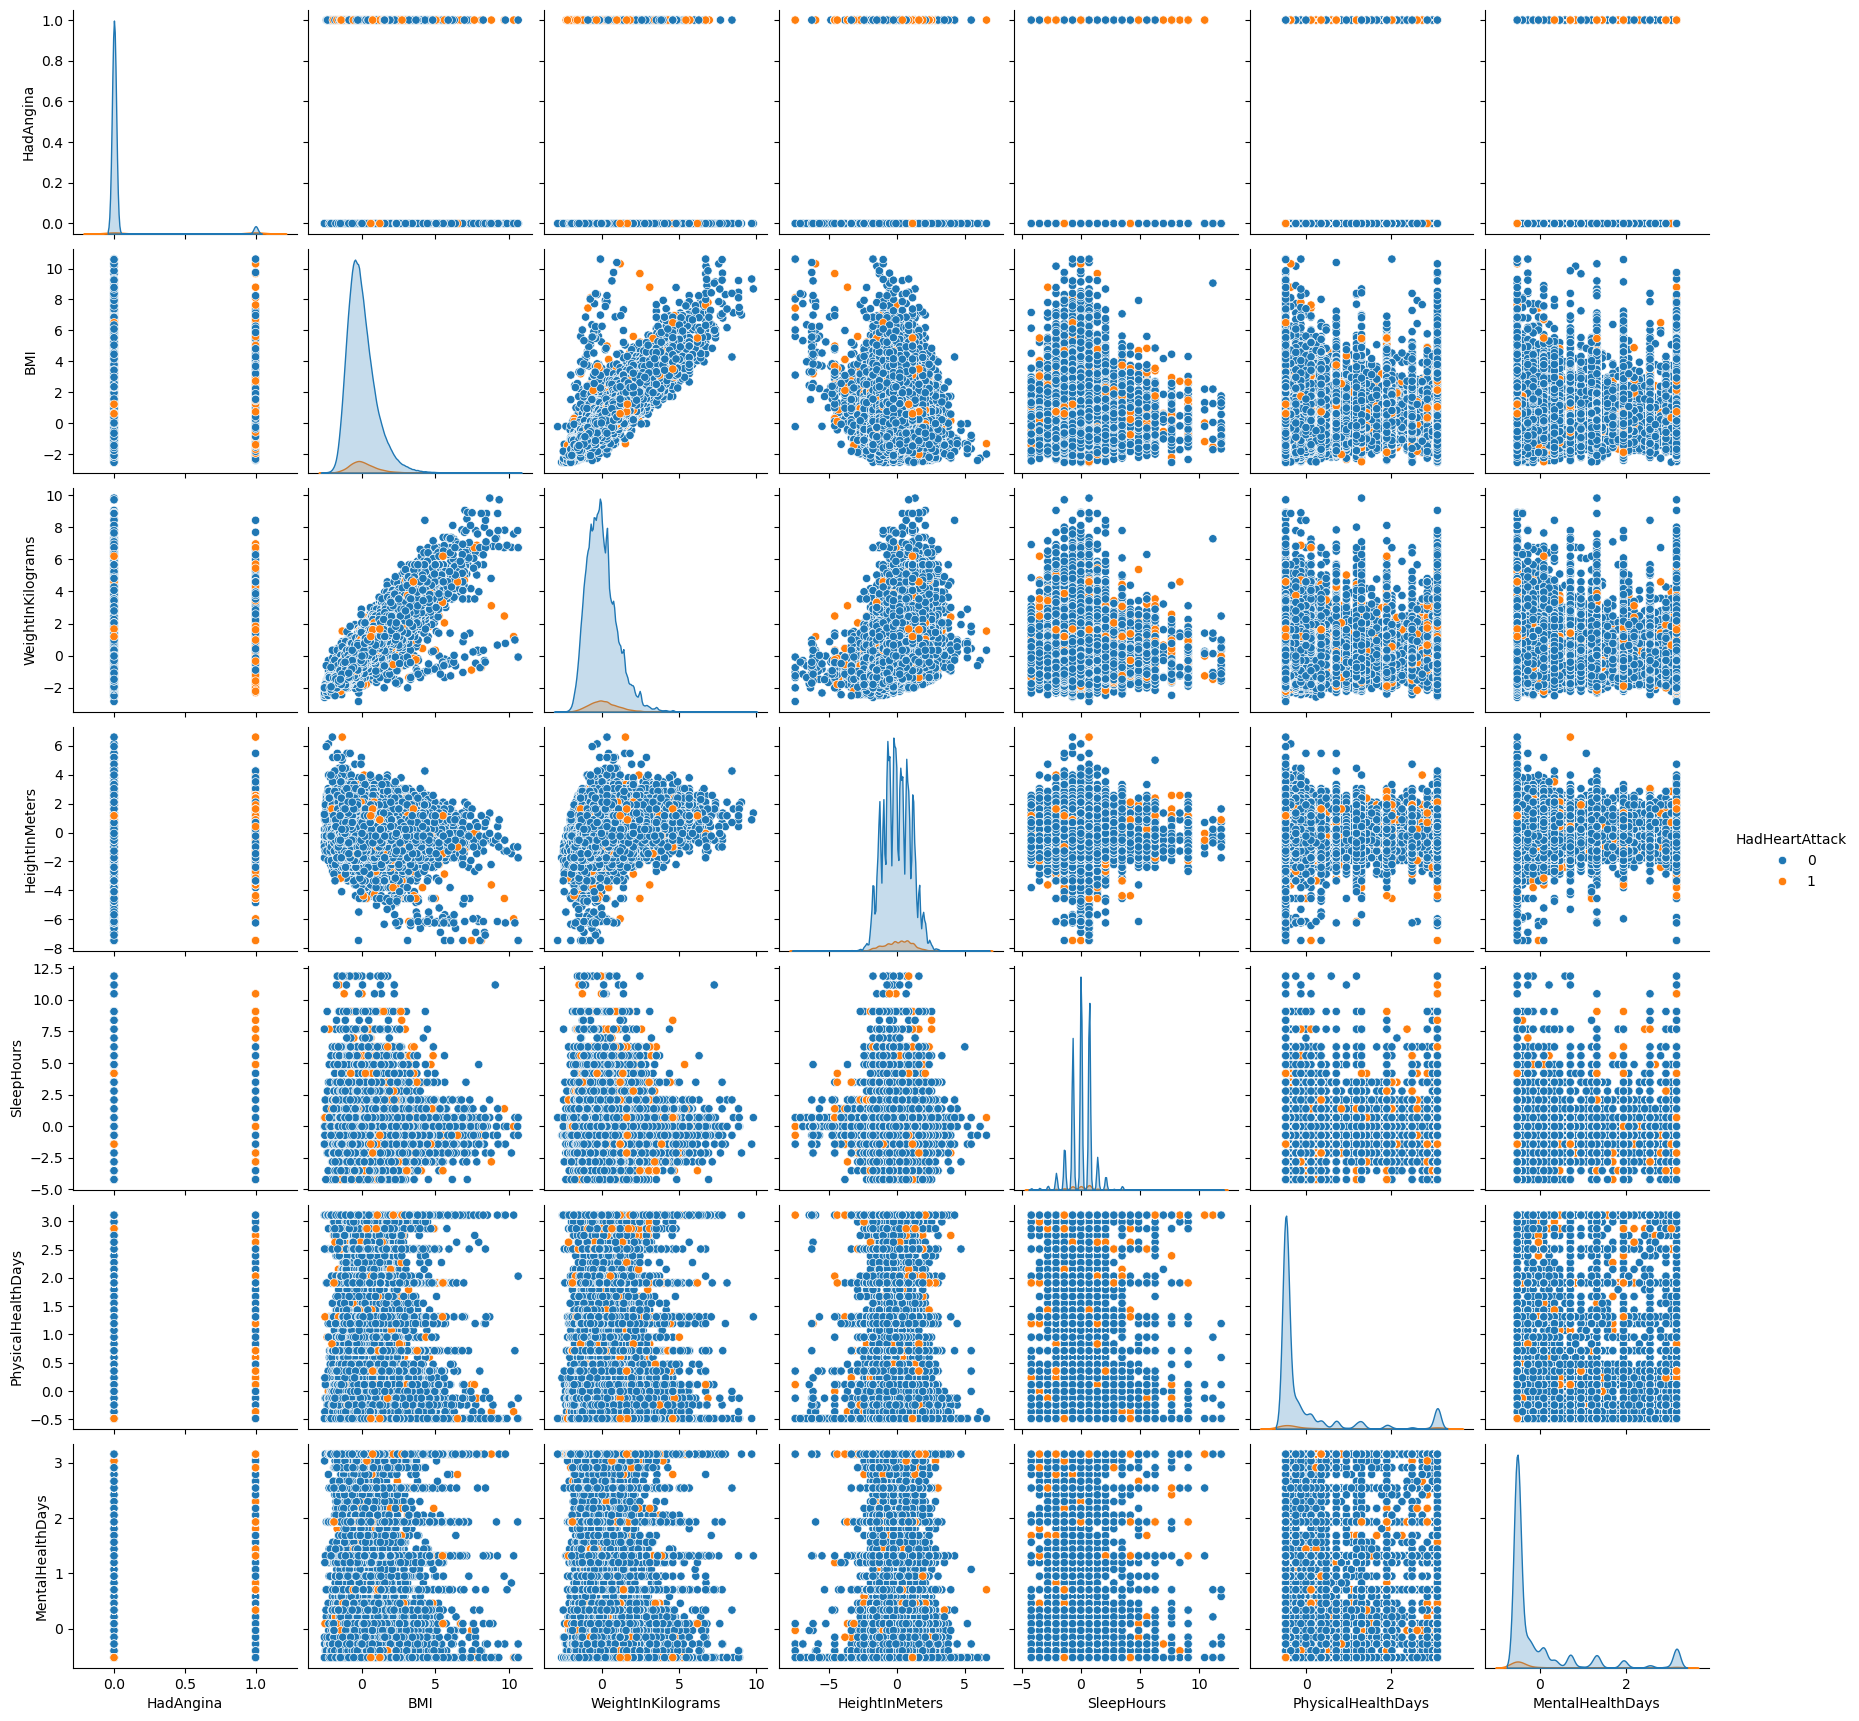

In [14]:
# Specify the columns you want to keep
columns_to_keep = ['HadAngina', 'BMI', 'WeightInKilograms', 'HeightInMeters', 'SleepHours', 'PhysicalHealthDays', 'MentalHealthDays']

# Select only the specified columns and add 'HadHeartAttack' for hue
data = df_cleaned[columns_to_keep + ['HadHeartAttack']]

# Visualize the statistical distribution of numeric features
sns.pairplot(data, hue='HadHeartAttack')
if not os.path.exists('pictures'):
    os.makedirs('pictures')
plt.savefig('pictures/pair_plot.png')
plt.show()

In [15]:
# Split Data into Features and Target
X = df_cleaned.drop(columns="HadHeartAttack")
y = df_cleaned.HadHeartAttack

In [16]:
# Train a RandomForestClassifier Model
model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [17]:
# Feature Importance Calculation
feautres_name = X.columns
importances =  model.feature_importances_
importance_df = pd.DataFrame({"Feature": feautres_name, "Importance": importances})
importance_df = importance_df.sort_values(by = "Importance", ascending=False)
importance_df

Feature  Importance
1                                           HadAngina    0.150700
72                                                BMI    0.086304
71                                  WeightInKilograms    0.077124
70                                     HeightInMeters    0.060916
69                                         SleepHours    0.048391
..                                                ...         ...
44                 ECigaretteUsage_Use them every day    0.001800
53                           AgeCategory_Age 30 to 34    0.001166
52                           AgeCategory_Age 25 to 29    0.000687
51                           AgeCategory_Age 18 to 24    0.000670
37  HadDiabetes_Yes, but only during pregnancy (fe...    0.000548

[73 rows x 2 columns]

<Axes: >

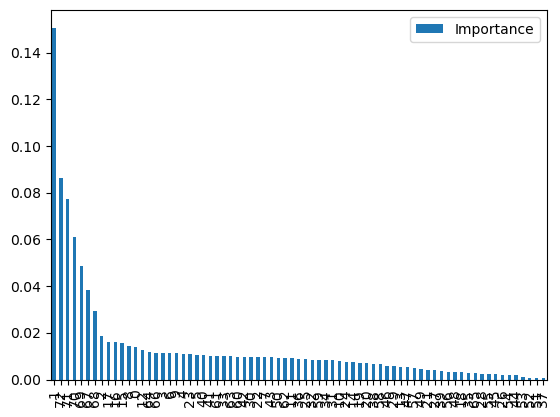

In [18]:
# Plotting Feature Importances
importance_df.plot(kind="bar")

In [19]:
# Filtering Important Features
important_features = importance_df[importance_df.Importance > 0.02]
important_features

Feature  Importance
1            HadAngina    0.150700
72                 BMI    0.086304
71   WeightInKilograms    0.077124
70      HeightInMeters    0.060916
69          SleepHours    0.048391
67  PhysicalHealthDays    0.038433
68    MentalHealthDays    0.029152

In [20]:
# Creating DataFrame with Important Features
important_df = df_cleaned[list(important_features.Feature)]
important_df.head()

HadAngina       BMI  WeightInKilograms  HeightInMeters  SleepHours  \
0          0 -0.092198          -0.554117       -0.995590    1.382336   
1          0  0.236631           0.551293        0.692103   -0.715670   
2          0  0.471730           1.189318        1.348428    0.683001   
3          0  0.419486           0.338931       -0.057983    1.382336   
4          0  0.688389          -0.192679       -1.464394   -1.415005   

   PhysicalHealthDays  MentalHealthDays  
0           -0.008726         -0.523179  
1           -0.488297         -0.523179  
2           -0.488297         -0.523179  
3            0.111167         -0.523179  
4           -0.128618          1.316711

In [21]:
# Creating DataFrame for PCA Data
pca_data = importance_df[~importance_df.Feature.isin(important_features.Feature)]
pca_data = df_cleaned[list(pca_data.Feature)]
pca_data.head()

HadStroke  FluVaxLast12  AlcoholDrinkers  ChestScan  HadArthritis  \
0          0             1                0          0             1   
1          0             1                0          0             1   
2          0             0                1          1             1   
3          0             1                0          0             1   
4          0             1                0          0             1   

   PhysicalActivities  DifficultyWalking  CovidPos_No  CovidPos_Yes  \
0                   1                  0            1             0   
1                   1                  0            1             0   
2                   0                  1            0             1   
3                   1                  1            0             1   
4                   1                  0            1             0   

   HadAsthma  ...  \
0          0  ...   
1          0  ...   
2          0  ...   
3          0  ...   
4          0  ...   

   LastCheckupTime_Within past 5 years (2 years but less than 5 years ago)  \
0                                                  0                         
1                                                  0                         
2                                                  0                         
3                                                  0                         
4                                                  0                         

   AgeCategory_Age 40 to 44  ECigaretteUsage_Use them some days  \
0                         0                                   0   
1                         0                                   0   
2                         0                                   0   
3                         0                                   0   
4                         0                                   0   

   LastCheckupTime_5 or more years ago  AgeCategory_Age 35 to 39  \
0                                    0                         0   
1                                    0                         0   
2                                    0                         0   
3                                    0                         0   
4                                    0                         0   

   ECigaretteUsage_Use them every day  AgeCategory_Age 30 to 34  \
0                                   0                         0   
1                                   0                         0   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   

   AgeCategory_Age 25 to 29  AgeCategory_Age 18 to 24  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   HadDiabetes_Yes, but only during pregnancy (female)  
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

[5 rows x 66 columns]

In [22]:
# Applying PCA to Data
pca = PCA(n_components=20)
X_pca = pca.fit_transform(pca_data)
pca.explained_variance_ratio_

array([0.09055776, 0.07345081, 0.05930419, 0.05308447, 0.04999135,
       0.04599243, 0.03980089, 0.03406913, 0.0317506 , 0.02892573,
       0.02793407, 0.02742073, 0.02547546, 0.02426244, 0.02296693,
       0.02112386, 0.01746921, 0.01628052, 0.01510261, 0.01442511])

In [23]:
# Explained Variance Ratio Calculation
pca.explained_variance_ratio_.sum()

0.7193882833945292

In [24]:
# Converting PCA Transformed Data to DataFrame
transformed_data = pd.DataFrame(X_pca)

In [25]:
# Concatenating Data for Final Prepared DataFrame
has_heart_attack_column = df_cleaned["HadHeartAttack"]
prepped_data = pd.concat([has_heart_attack_column, important_df, transformed_data], axis=1)
prepped_data

HadHeartAttack  HadAngina       BMI  WeightInKilograms  \
0                    0          0 -0.092198          -0.554117   
1                    0          0  0.236631           0.551293   
2                    0          0  0.471730           1.189318   
3                    0          0  0.419486           0.338931   
4                    0          0  0.688389          -0.192679   
...                ...        ...       ...                ...   
296347               0          0 -0.653053           0.338931   
296348               0          0  0.195144           0.019684   
296349               0          0  0.399510           0.976956   
296350               0          0  0.010753          -0.022507   
296351               1          0  0.608486           1.189318   

        HeightInMeters  SleepHours  PhysicalHealthDays  MentalHealthDays  \
0            -0.995590    1.382336           -0.008726         -0.523179   
1             0.692103   -0.715670           -0.488297         -0.523179   
2             1.348428    0.683001           -0.488297         -0.523179   
3            -0.057983    1.382336            0.111167         -0.523179   
4            -1.464394   -1.415005           -0.128618          1.316711   
...                ...         ...                 ...               ...   
296347        2.098514   -0.016335           -0.488297          0.335436   
296348       -0.245504   -0.016335           -0.488297          1.316711   
296349        1.160907    0.683001           -0.488297         -0.523179   
296350       -0.057983   -0.016335           -0.248511         -0.277860   
296351        1.160907   -1.415005           -0.488297         -0.523179   

               0         1  ...        10        11        12        13  \
0       0.190646 -0.593205  ... -0.394543 -0.013256  0.234213 -0.344529   
1       0.372658  0.683078  ... -0.363077  0.791572 -0.219801  0.069140   
2       0.783725  0.914815  ...  0.573267 -0.249424 -0.210076 -0.415086   
3       0.254279 -1.201489  ... -0.610626  0.357796  0.528920 -0.553477   
4       0.632813 -0.865012  ... -0.588611 -0.022007  0.192720 -0.323820   
...          ...       ...  ...       ...       ...       ...       ...   
296347 -0.582880 -1.060347  ...  0.060499 -0.084622  0.147439 -0.545355   
296348  0.455054  0.415810  ...  0.423796  0.932370 -0.134353  0.085298   
296349 -1.315311  0.546657  ...  0.181738  0.388867  0.175168  0.441108   
296350 -0.630435 -1.006061  ... -0.386376 -0.319755  0.266543 -0.116517   
296351 -0.438137  0.153833  ...  0.132654 -0.766758  0.680932 -0.065624   

              14        15        16        17        18        19  
0      -0.485648 -0.411175 -0.097127 -0.027998  0.587939  0.661108  
1      -0.343385 -0.650218 -0.284742 -0.136480  0.051840 -0.490707  
2      -0.638743  0.755870  0.249830 -0.179093 -0.242430 -0.219574  
3      -0.240270 -0.344029 -0.083228 -0.314739 -0.581561  0.402216  
4      -0.435295 -0.225233 -0.108430 -0.054760 -0.213072  0.132959  
...          ...       ...       ...       ...       ...       ...  
296347  0.403070 -0.466329  0.189567 -0.233314 -0.177096  0.174752  
296348 -0.569849 -0.448306  0.142111 -0.067258  0.614034  0.516755  
296349 -0.217153  0.077102  0.045088 -0.045566 -0.233027  0.100232  
296350 -0.088436 -0.187466  0.170263 -0.067703  0.171803 -0.169743  
296351  0.099365  0.523213 -0.265352  0.729463  0.264932 -0.729025  

[296352 rows x 28 columns]

In [26]:
# Balancing the Dataset by Removing a Fraction of Majority Class
fract_remove = 0.80
majority_data = prepped_data[prepped_data.HadHeartAttack == 0]
count_of_majority = len(majority_data)
minority_data = prepped_data[prepped_data.HadHeartAttack == 1]
sample_remove = majority_data.sample(int(fract_remove * count_of_majority)).index
majority_data = majority_data.drop(sample_remove)

In [27]:
# Combining Balanced Majority and Minority Data
final_data = pd.concat([majority_data, minority_data], axis = "rows")

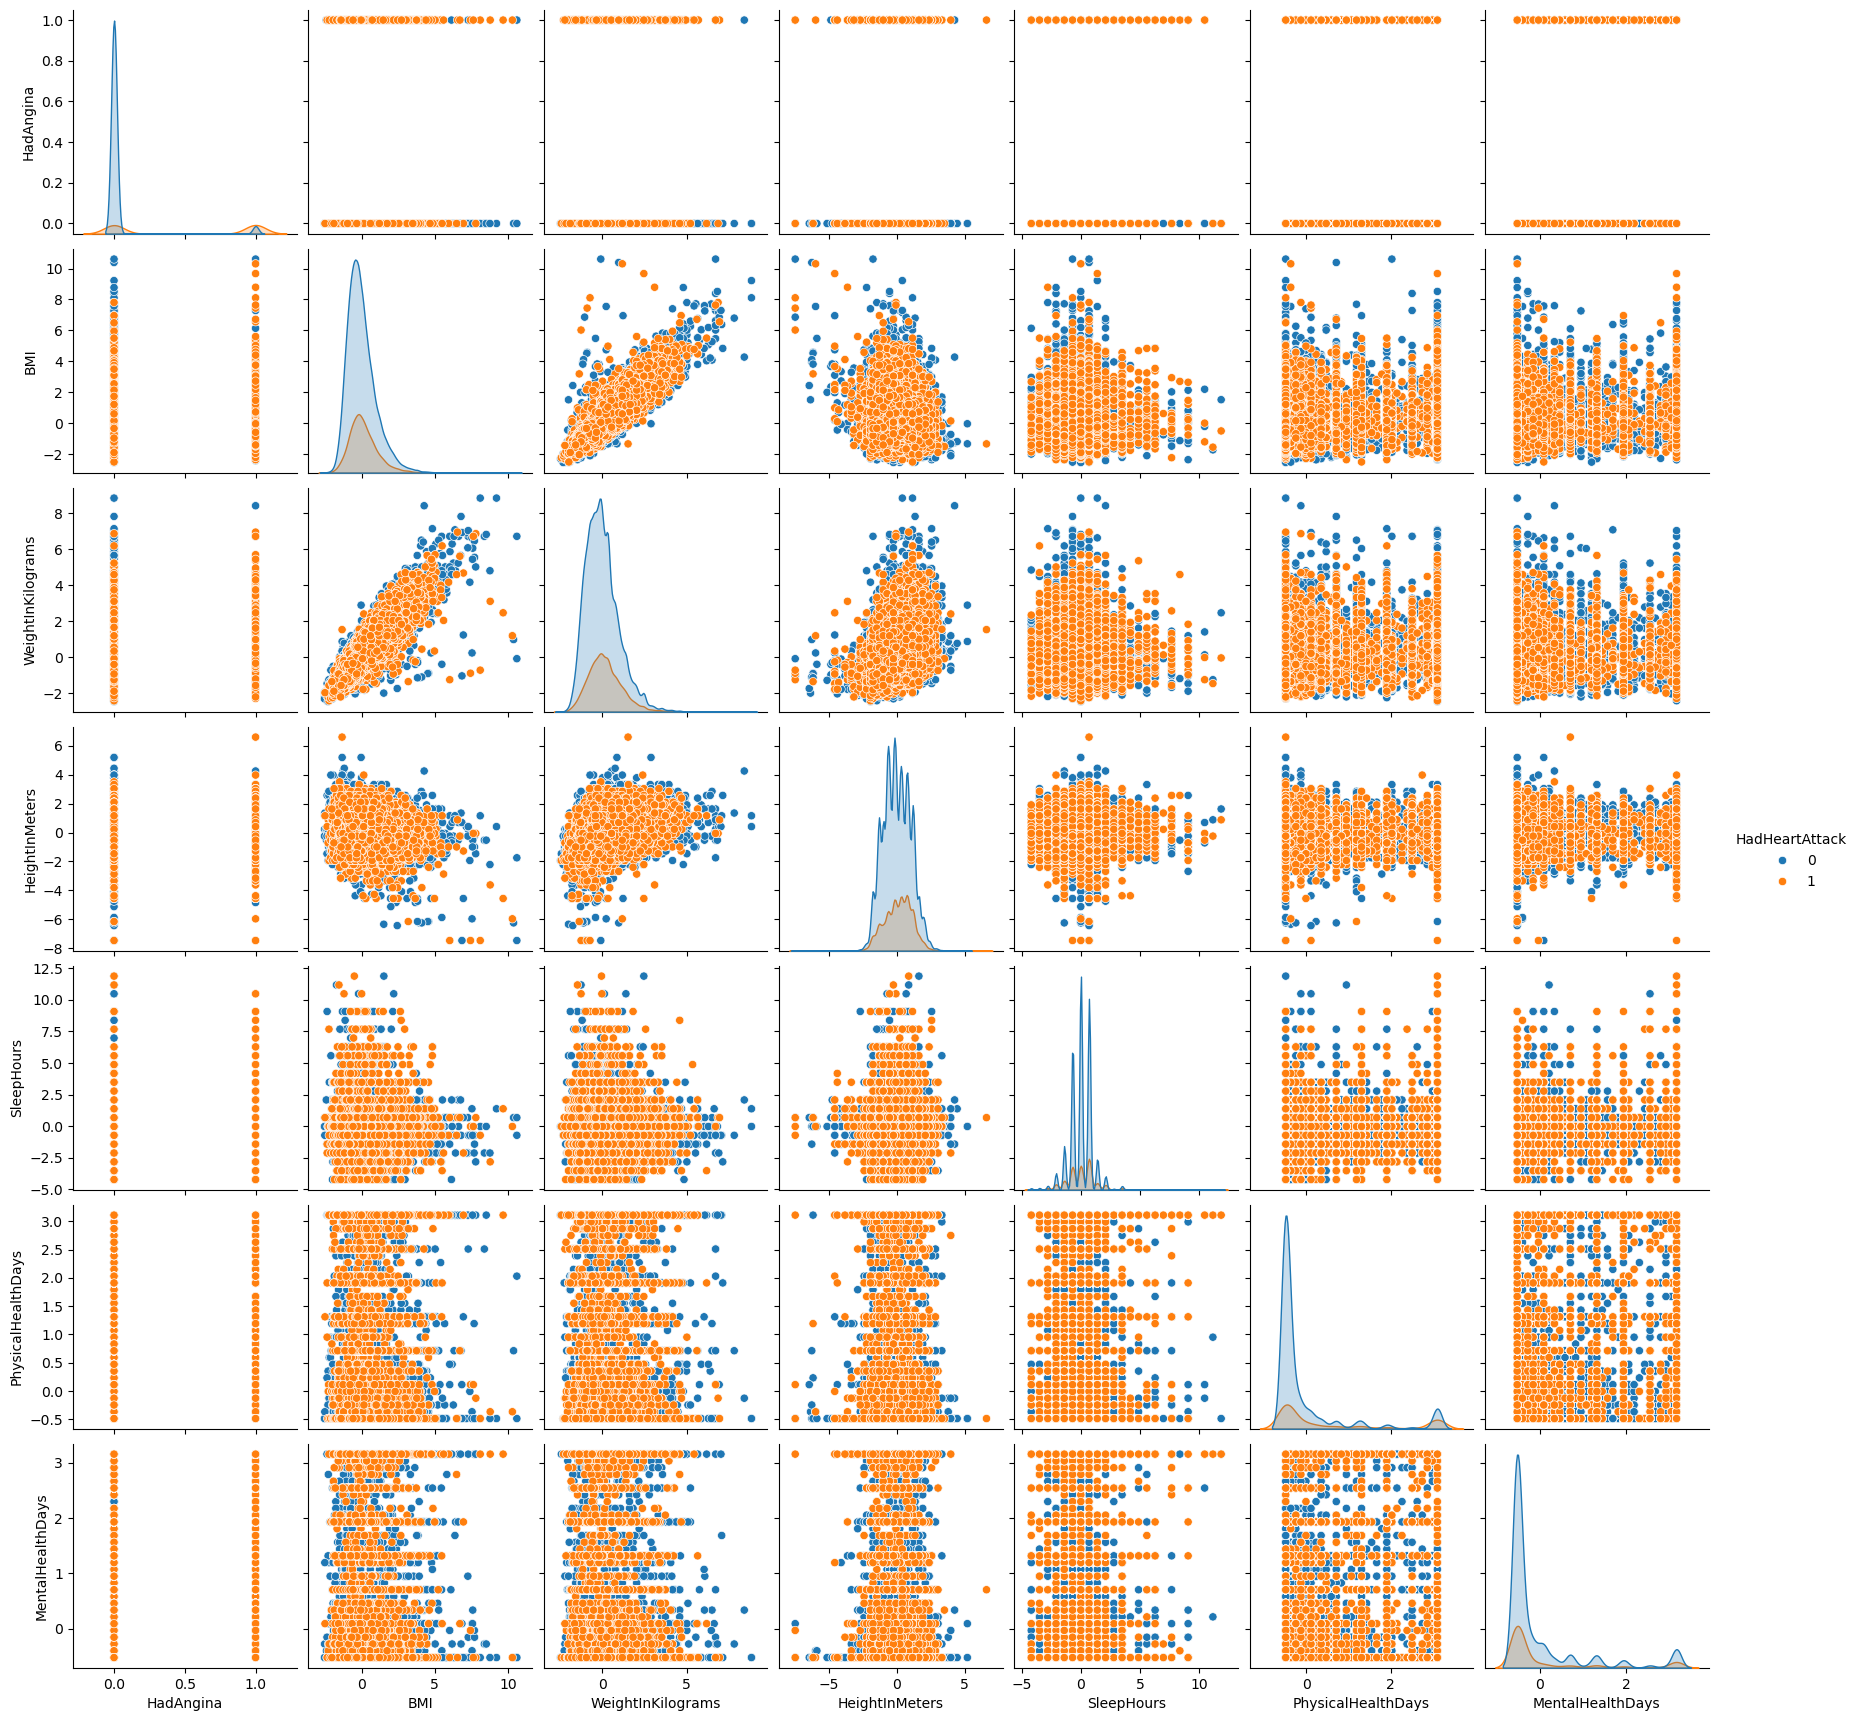

In [28]:
# Combine the balanced majority class data with the minority class data
balanced_df = pd.concat([majority_data, minority_data])

# Select only the specified columns and add 'HadHeartAttack' for hue
data = balanced_df[columns_to_keep + ['HadHeartAttack']]

# Visualize the statistical distribution of numeric features
sns.pairplot(data, hue='HadHeartAttack')
if not os.path.exists('pictures'):
    os.makedirs('pictures')
plt.savefig('pictures/pair_plot.png')
plt.show()

In [29]:
# Calculating the Proportions of Majority and Minority Classes in Final Data
len(majority_data)/len(final_data), len(minority_data)/len(final_data)

(0.78364049834675, 0.21635950165325)

In [30]:
# Saving the Final Data to CSV File
final_data.to_csv("ready_for_ML.csv", index=False)

In [31]:
# Load data set into pandas
df = pd.read_csv("ready_for_ML.csv")
df.head()

HadHeartAttack  HadAngina       BMI  WeightInKilograms  HeightInMeters  \
0               0          0 -0.092198          -0.554117       -0.995590   
1               0          0  1.233878           1.827343        1.160907   
2               0          0 -0.468663          -0.341754        0.223299   
3               0          0 -1.298421          -1.341217       -0.526787   
4               0          0  1.508927           0.551293       -1.276872   

   SleepHours  PhysicalHealthDays  MentalHealthDays         0         1  ...  \
0    1.382336           -0.008726         -0.523179  0.190646 -0.593205  ...   
1    0.683001           -0.488297         -0.523179 -0.107264  0.573883  ...   
2   -0.016335           -0.488297         -0.523179  0.864752 -0.497274  ...   
3    2.081671           -0.488297         -0.523179  1.021563 -0.393906  ...   
4    0.683001           -0.488297         -0.523179  1.054569 -0.933294  ...   

         10        11        12        13        14        15        16  \
0 -0.394543 -0.013256  0.234213 -0.344529 -0.485648 -0.411175 -0.097127   
1  0.174135 -0.442119  0.065295  0.208481  0.368487  0.295601 -0.042289   
2 -0.312072 -0.739737  0.109413  0.295916  0.499384  0.169930  0.949546   
3  0.334397 -0.346189 -0.032496  0.172794  0.135742  1.386621  0.539093   
4 -0.590771  0.961926 -0.314093  0.256012 -0.397062 -0.368727 -0.145572   

         17        18        19  
0 -0.027998  0.587939  0.661108  
1 -0.063058 -0.275902  0.112890  
2  0.880952  0.845814  0.498851  
3 -0.050247  0.047763 -0.402414  
4 -0.048629 -0.240854 -0.019724  

[5 rows x 28 columns]

In [32]:
# Split the data into training and testing sets
X = df.drop(columns="HadHeartAttack")
y = df["HadHeartAttack"]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, test_size=0.3, random_state=42, stratify=y)

# Create and fit the Logistic Regression model with class weights
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42, class_weight='balanced')
classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test = classifier.predict(X_test)
print("Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))


Test Set Evaluation:
Accuracy: 0.8183128720238095
Confusion Matrix:
 [[14071  2780]
 [ 1127  3526]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88     16851
           1       0.56      0.76      0.64      4653

    accuracy                           0.82     21504
   macro avg       0.74      0.80      0.76     21504
weighted avg       0.85      0.82      0.83     21504



In [33]:
# Create and fit the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_rf = rf_classifier.predict(X_test)
print("Random Forest Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_test_rf))


Random Forest Test Set Evaluation:
Accuracy: 0.8620721726190477
Confusion Matrix:
 [[16168   683]
 [ 2283  2370]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     16851
           1       0.78      0.51      0.62      4653

    accuracy                           0.86     21504
   macro avg       0.83      0.73      0.77     21504
weighted avg       0.85      0.86      0.85     21504



In [34]:
# Create and fit the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_gb = gb_classifier.predict(X_test)
print("Gradient Boosting Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_test_gb))


Gradient Boosting Test Set Evaluation:
Accuracy: 0.8663039434523809
Confusion Matrix:
 [[16150   701]
 [ 2174  2479]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     16851
           1       0.78      0.53      0.63      4653

    accuracy                           0.87     21504
   macro avg       0.83      0.75      0.78     21504
weighted avg       0.86      0.87      0.86     21504



In [35]:
# Create and fit the XGBoost model
xgb_classifier = xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]))
xgb_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_xgb = xgb_classifier.predict(X_test)
print("XGBoost Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_test_xgb))


XGBoost Test Set Evaluation:
Accuracy: 0.8189639136904762
Confusion Matrix:
 [[14271  2580]
 [ 1313  3340]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88     16851
           1       0.56      0.72      0.63      4653

    accuracy                           0.82     21504
   macro avg       0.74      0.78      0.76     21504
weighted avg       0.84      0.82      0.83     21504



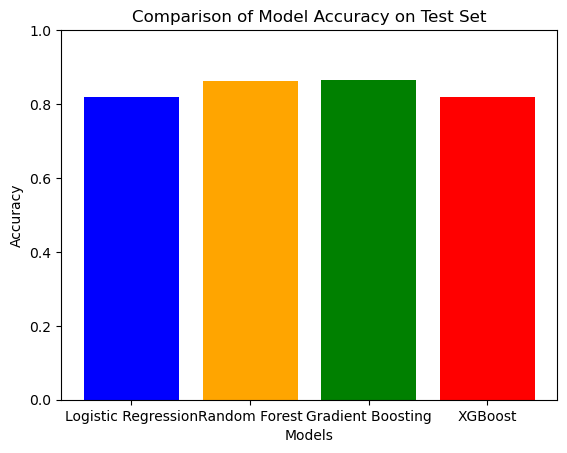

In [36]:
# Plot the comparison of accuracy
labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_test),
    accuracy_score(y_test, y_pred_test_rf),
    accuracy_score(y_test, y_pred_test_gb),
    accuracy_score(y_test, y_pred_test_xgb)
]

plt.bar(labels, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy on Test Set')
plt.ylim(0, 1)
plt.show()


$$ Precision = TP /(TP + FP) $$

$$ Recall = TP / (TP + FN) $$

True Negatives (TN): 14071: Model correctly predicted no heart attack (HadHeartAttack = 0).
False Positives (FP): 2780: Model incorrectly predicted a heart attack when there wasn't one.
False Negatives (FN): 1127: Model incorrectly predicted no heart attack when there actually was one.
True Positives (TP): 3526: Model correctly predicted a heart attack (HadHeartAttack = 1).



76% of actual heart attack cases were correctly identified by the model. High recall is essential for ensuring that most cases are caught, and the model compensates for the low precision.

In [37]:
# Load data set into pandas
data = pd.read_csv("Cleaned_dataset.csv")

In [38]:
# Defining Columns to Keep for Feature Selection Models
columns_to_keep = ['HadAngina', 'BMI', 'WeightInKilograms', 
                   'HeightInMeters', 'SleepHours', 
                   'PhysicalHealthDays', 'MentalHealthDays']

In [39]:
# Creating DataFrame with Selected Columns and Target Column
df = data[columns_to_keep]
df["HadHeartAttack"] = data.HadHeartAttack

In [40]:
# Encoding Categorical Columns
encoder = LabelEncoder()
df["HadAngina"] = encoder.fit_transform(df.HadAngina)
df["HadHeartAttack"] = encoder.fit_transform(df["HadHeartAttack"])

In [41]:
# Saving Label Encoder to a File
joblib.dump(encoder,"label_encoder.pkl")

['label_encoder.pkl']

In [42]:
# Scaling Numeric Columns
scaler = MinMaxScaler()
col_to_scale = df.select_dtypes(include="float64")
scaled_columns = scaler.fit_transform(col_to_scale)
scaled_data = pd.DataFrame(scaled_columns, columns=col_to_scale.columns)

In [43]:
# Saving Label scaler to a File
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [44]:
# Creating Final Prepped Data by Concatenating Scaled and Encoded Columns
prepped_data = pd.concat([scaled_data,df[["HadAngina","HadHeartAttack"]]],axis="columns")

In [45]:
# Training the RandomForestClassifier Model
model = RandomForestClassifier()
X = prepped_data.drop(columns="HadHeartAttack").values
y = prepped_data.HadHeartAttack.values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3, shuffle=True, stratify=y)
model.fit(x_train,y_train)

RandomForestClassifier()

In [46]:
# Evaluating the RandomForestClassifier Model
model.score(x_test,y_test)

0.9438508087193215

In [47]:
# Saving Label model to a File
joblib.dump(model,"rf_classifier.pkl")

['rf_classifier.pkl']